In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [4]:
path="/content/drive/MyDrive/Assignment/"
transactions = pd.read_csv(path+'Transactions.csv')
products= pd.read_csv(path+'Products.csv')
customers = pd.read_csv(path+'Customers.csv')

# Feature Engineering

In [15]:
# Customer purchase metrics
purchase_features = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    }).round(2)
purchase_features.head()

TransactionID TotalValue         Quantity      
                   count        sum    mean      sum  mean
CustomerID                                                
C0001                  5    3354.52  670.90       12  2.40
C0002                  4    1862.74  465.68       10  2.50
C0003                  4    2725.38  681.34       14  3.50
C0004                  8    5354.88  669.36       23  2.88
C0005                  3    2034.24  678.08        7  2.33

In [16]:
# Flatten column names
purchase_features.columns = ['_'.join(col).strip('_') for col in purchase_features.columns.values]

# Convert 'TransactionDate' to datetime before calculations
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

 # Add recency feature
last_purchase = transactions.groupby('CustomerID')['TransactionDate'].max()
first_purchase = transactions.groupby('CustomerID')['TransactionDate'].min()
purchase_features['customer_lifetime_days'] = (last_purchase - first_purchase).dt.days

purchase_features.head()

,TransactionID_count,TotalValue_sum,TotalValue_mean,Quantity_sum,Quantity_mean,customer_lifetime_days
CustomerID,,,,,,
C0001,5,3354.52,670.90,12,2.40,288
C0002,4,1862.74,465.68,10,2.50,278
C0003,4,2725.38,681.34,14,3.50,188
C0004,8,5354.88,669.36,23,2.88,299
C0005,3,2034.24,678.08,7,2.33,233


In [18]:
# Category preferences
trans_with_cat = pd.merge(transactions, products[['ProductID', 'Category']], on='ProductID')
category_pivot = pd.pivot_table(
        trans_with_cat,
        index='CustomerID',
        columns='Category',
        values='TotalValue',
        aggfunc='sum',
        fill_value=0
    )
category_pivot.head()

Category,Books,Clothing,Electronics,Home Decor
CustomerID,,,,
C0001,114.60,0.00,2827.30,412.62
C0002,0.00,1025.46,0.00,837.28
C0003,0.00,122.36,1385.20,1217.82
C0004,1888.48,0.00,1355.74,2110.66
C0005,0.00,0.00,1180.38,853.86


In [19]:
# Region encoding
region_dummies = pd.get_dummies(customers['Region'], prefix='Region')

In [21]:
# Combine all features
features = pd.concat([
        purchase_features,
        category_pivot,
        region_dummies
    ], axis=1).fillna(0)

features.head()

,TransactionID_count,TotalValue_sum,TotalValue_mean,Quantity_sum,Quantity_mean,customer_lifetime_days,Books,Clothing,Electronics,Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America
C0001,5.0,3354.52,670.90,12.0,2.40,288.0,114.60,0.00,2827.30,412.62,0,0,0,0
C0002,4.0,1862.74,465.68,10.0,2.50,278.0,0.00,1025.46,0.00,837.28,0,0,0,0
C0003,4.0,2725.38,681.34,14.0,3.50,188.0,0.00,122.36,1385.20,1217.82,0,0,0,0
C0004,8.0,5354.88,669.36,23.0,2.88,299.0,1888.48,0.00,1355.74,2110.66,0,0,0,0
C0005,3.0,2034.24,678.08,7.0,2.33,233.0,0.00,0.00,1180.38,853.86,0,0,0,0


# Model Training and Evaluation

In [26]:
def train_and_evaluate(features, max_clusters=10):
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Store metrics
    metrics = []

    # Try different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(features_scaled)

        db_score = davies_bouldin_score(features_scaled, clusters)
        silhouette = silhouette_score(features_scaled, clusters)

        metrics.append({
            'n_clusters': n_clusters,
            'db_score': db_score,
            'silhouette': silhouette
        })

    return pd.DataFrame(metrics)

train_and_evaluate(features)

,n_clusters,db_score,silhouette
0,2,0.847775,0.185537
1,3,0.938977,0.421960
2,4,0.812908,0.541637
3,5,0.556735,0.654340
4,6,0.849356,0.609015
5,7,0.909395,0.596073
6,8,1.051485,0.576222
7,9,1.041844,0.585847
8,10,0.993888,0.597005


In [32]:
# Final Model
def create_final_clustering(features, n_clusters):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_scaled)

    # Add cluster labels to features
    features_with_clusters = features.copy()
    features_with_clusters['Cluster'] = clusters

    return features_with_clusters, kmeans

features_with_clusters, model = create_final_clustering(features, 5)
features_with_clusters.head()

,TransactionID_count,TotalValue_sum,TotalValue_mean,Quantity_sum,Quantity_mean,customer_lifetime_days,Books,Clothing,Electronics,Home Decor,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
C0001,5.0,3354.52,670.90,12.0,2.40,288.0,114.60,0.00,2827.30,412.62,0,0,0,0,2
C0002,4.0,1862.74,465.68,10.0,2.50,278.0,0.00,1025.46,0.00,837.28,0,0,0,0,2
C0003,4.0,2725.38,681.34,14.0,3.50,188.0,0.00,122.36,1385.20,1217.82,0,0,0,0,2
C0004,8.0,5354.88,669.36,23.0,2.88,299.0,1888.48,0.00,1355.74,2110.66,0,0,0,0,2
C0005,3.0,2034.24,678.08,7.0,2.33,233.0,0.00,0.00,1180.38,853.86,0,0,0,0,2


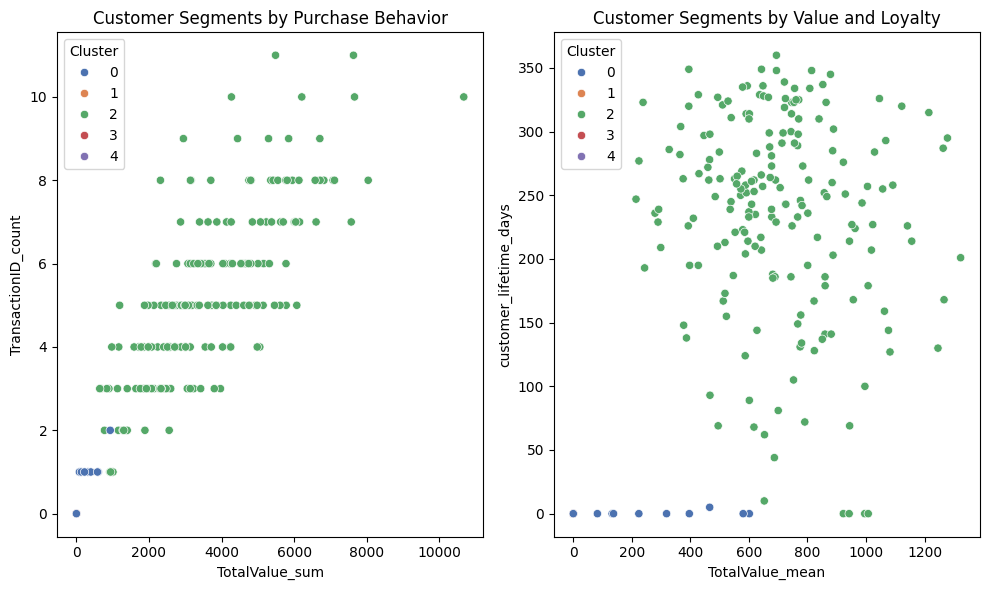

In [30]:
# Visualizations
def plot_clusters(features_with_clusters):
    plt.figure(figsize=(10, 6))

    # Plot 1: Purchase Behavior
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        data=features_with_clusters,
        x='TotalValue_sum',
        y='TransactionID_count',
        hue='Cluster',
        palette='deep'
    )
    plt.title('Customer Segments by Purchase Behavior')

    # Plot 2: Average Order Value vs Frequency
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        data=features_with_clusters,
        x='TotalValue_mean',
        y='customer_lifetime_days',
        hue='Cluster',
        palette='deep'
    )
    plt.title('Customer Segments by Value and Loyalty')

    plt.tight_layout()
    plt.show()

plot_clusters(features_with_clusters)

# Final Outcomes


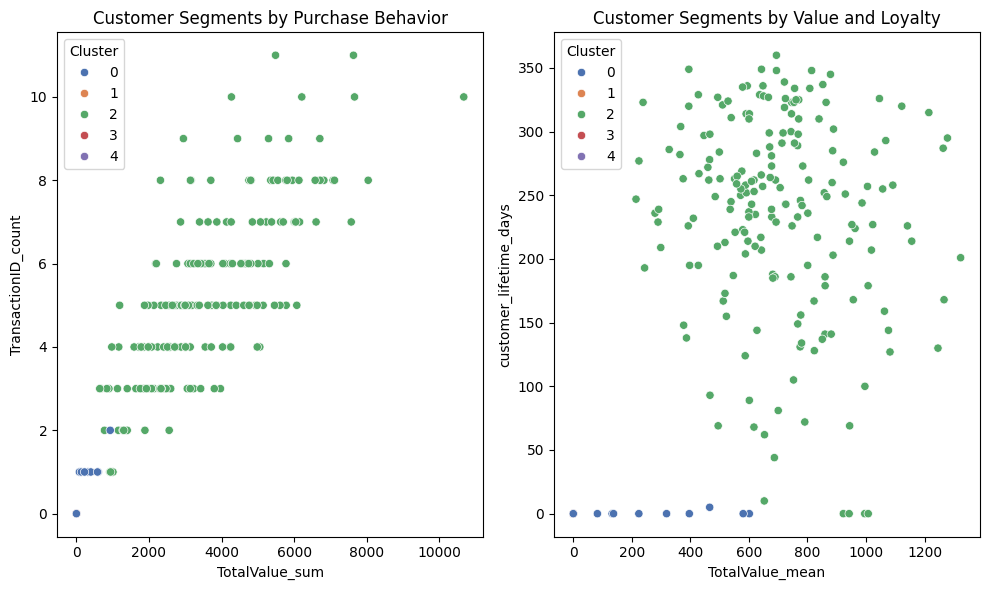


Clustering Results Report
--------------------------------------------------
Number of clusters: 5
Davies-Bouldin Index: 0.5567
Silhouette Score: 0.6543

Cluster Sizes:
Cluster
2    190
1     59
0     54
3     50
4     46
Name: count, dtype: int64


In [31]:
def Clustering_Results():
    # Evaluate different cluster numbers
    metrics = train_and_evaluate(features)

    # Select optimal number of clusters (lowest DB score)
    optimal_clusters = metrics.loc[metrics['db_score'].idxmin(), 'n_clusters']

    # Create final clustering
    features_with_clusters, model = create_final_clustering(features, optimal_clusters)

    # Generate visualizations
    plot_clusters(features_with_clusters)

    # Print report
    print("\nClustering Results Report")
    print("-" * 50)
    print(f"Number of clusters: {optimal_clusters}")
    print(f"Davies-Bouldin Index: {metrics['db_score'].min():.4f}")
    print(f"Silhouette Score: {metrics.loc[metrics['db_score'].idxmin(), 'silhouette']:.4f}")
    print("\nCluster Sizes:")
    print(features_with_clusters['Cluster'].value_counts())

Clustering_Results()